In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Loading the data and editing the date format

In [318]:
df = pd.read_csv('flights/flights.csv', dtype=str)
df = df.loc[~df[['DEPARTURE_TIME', 'ARRIVAL_TIME']].isna().any(axis=1)]

df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
cols = list(df.columns)
df = df[cols[-1:] + cols[:-1]]

df.head()

,DATE,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015-01-01,4,AS,98,N407AS,ANC,SEA,0005,2354,-11,...,0408,-22,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01,4,AA,2336,N3KUAA,LAX,PBI,0010,0002,-8,...,0741,-9,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-01,4,US,840,N171US,SFO,CLT,0020,0018,-2,...,0811,5,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-01,4,AA,258,N3HYAA,LAX,MIA,0020,0015,-5,...,0756,-9,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-01-01,4,AS,135,N527AS,SEA,ANC,0025,0024,-1,...,0259,-21,0,0,NaN,NaN,NaN,NaN,NaN,NaN


Loading airport name info

In [319]:
air = pd.read_csv('flights/airports.csv', dtype = str)
air.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


Leaving only existing airports lines

In [320]:
df = df.loc[df.ORIGIN_AIRPORT.isin(air.IATA_CODE) & df.DESTINATION_AIRPORT.isin(air.IATA_CODE)]

1. Avg departure delay daily by hours

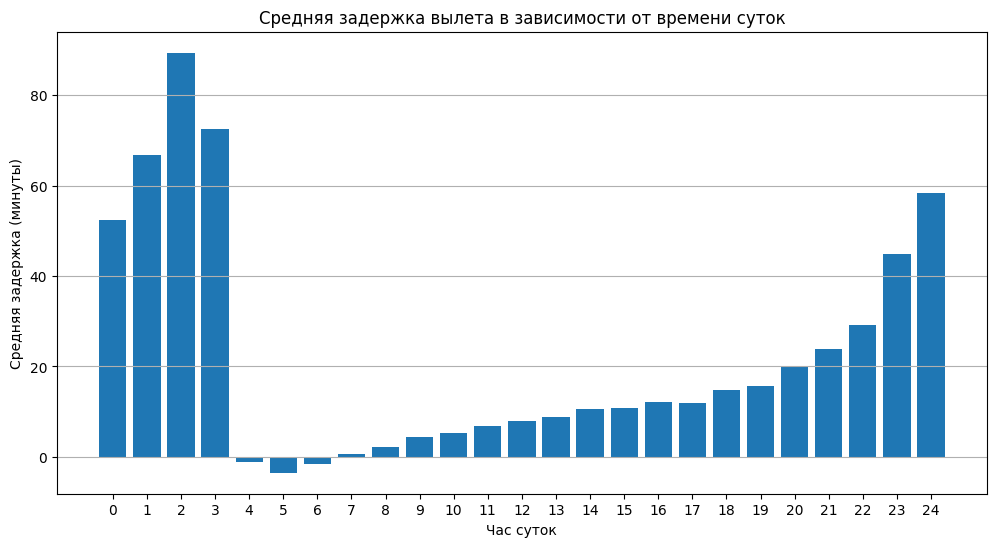

In [321]:
df['DEPARTURE_DELAY'] = pd.to_numeric(df['DEPARTURE_DELAY'], errors='coerce')
df['HOUR'] = (df['DEPARTURE_TIME'].astype(int) // 100).astype(int)
plt.figure(figsize=(12, 6))
plt.bar(np.arange(25), df.groupby('HOUR')['DEPARTURE_DELAY'].mean().dropna())
#df = df.drop(columns=['HOUR'])

plt.title('Средняя задержка вылета в зависимости от времени суток')
plt.xlabel('Час суток')
plt.ylabel('Средняя задержка (минуты)')
plt.xticks(np.arange(25))
plt.grid(axis='y')
plt.show()

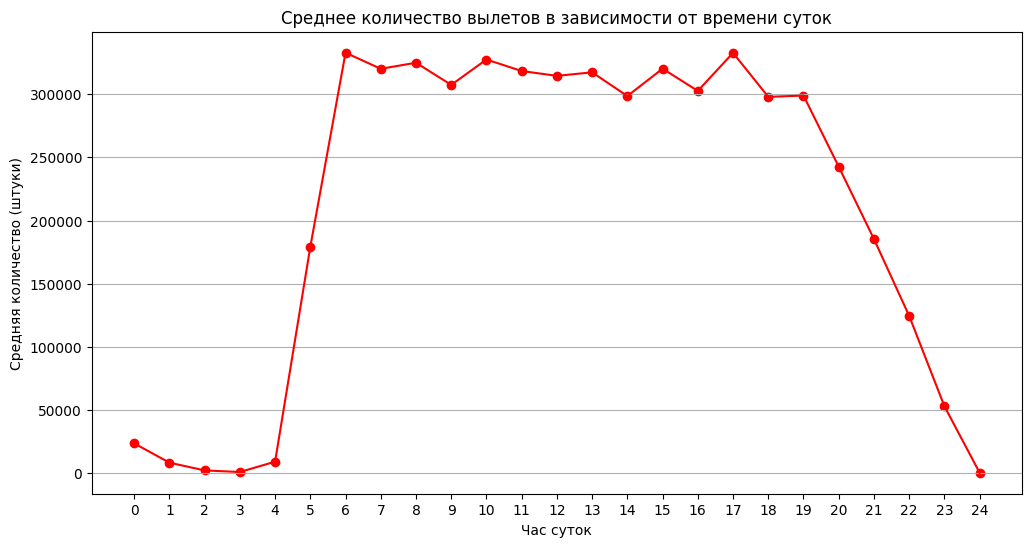

In [322]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(25), df.groupby("HOUR").size(), color = "red")
plt.scatter(np.arange(25), df.groupby("HOUR").size(), color = "red")
plt.title('Среднее количество вылетов в зависимости от времени суток')
plt.xlabel('Час суток')
plt.ylabel('Средняя количество (штуки)')
plt.xticks(np.arange(25))
plt.grid(axis='y')
plt.show()

In [323]:
print("Corr = ", np.corrcoef(df.groupby('HOUR')['DEPARTURE_DELAY'].mean(), df.groupby("HOUR").size())[0,1])
df = df.drop(columns=['HOUR'])

Corr =  -0.7946598646392379


We can see that the night flights (12 p.m. - 3 a.m.) are less effective, maybe due to the fact that humans are less efficient at nighttime and there are more mistakes to appear. What we can do here is try to change the watch right before midnight, so the fresh workers will bring less mistake opportunities.

The correlation between the amount of flights and the mean delay is -.79, which basically means that the series are almoust perfectly negatively correlated. Maybe this is because when there are less flights we pay less attention to them, and the delays appear. So by any chance call a meeting and tell the workers to be more propper at night, even though there are not much to look for.

2. Checking the worst airports by delaytime

Corr =  0.24454716793562947


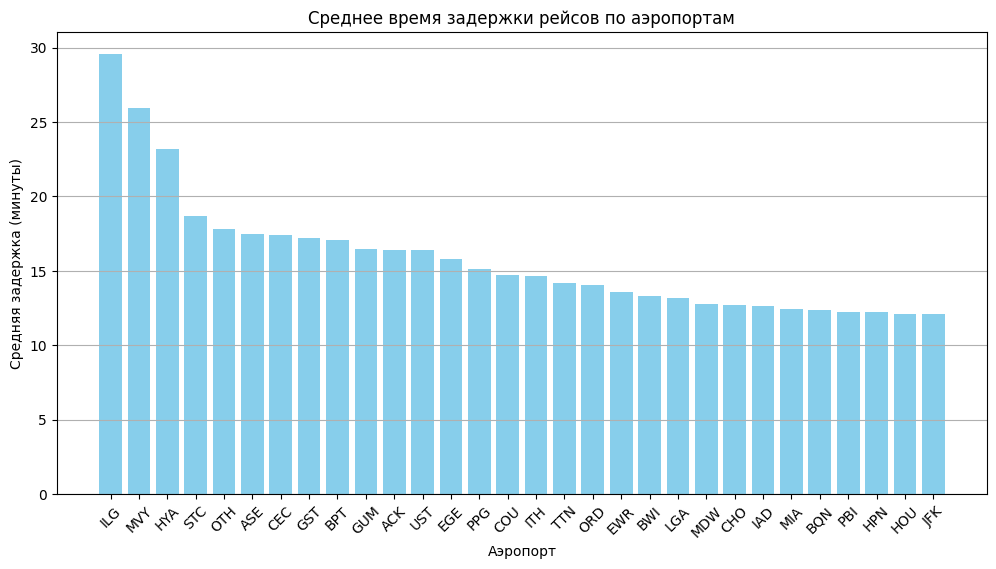

In [324]:
avg_delay_by_airport = df.groupby('ORIGIN_AIRPORT')['DEPARTURE_DELAY'].mean().reset_index().dropna()
avg_delay_by_airport = avg_delay_by_airport.sort_values(by='DEPARTURE_DELAY', ascending=False)

df['ROUTE'] = df['ORIGIN_AIRPORT'] + df['DESTINATION_AIRPORT']
tmp = df.groupby('ORIGIN_AIRPORT')['ROUTE'].nunique().reset_index()
tmp = tmp.merge(avg_delay_by_airport, on = 'ORIGIN_AIRPORT').sort_values(by = 'DEPARTURE_DELAY', ascending=False)
print('Corr = ', tmp['ROUTE'].corr(tmp['DEPARTURE_DELAY']))

plt.figure(figsize=(12, 6))
plt.bar(avg_delay_by_airport['ORIGIN_AIRPORT'][:30], avg_delay_by_airport['DEPARTURE_DELAY'][:30], color='skyblue')
plt.title('Среднее время задержки рейсов по аэропортам')
plt.xlabel('Аэропорт')
plt.ylabel('Средняя задержка (минуты)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

As we can see we have a list of airports, which cause the most of the delay problems. The correlation between the number of flights and the mean delays is a bit weak, which means that not the amount of taken flights is the problem, but the airport is. So maybe talk to the airport management about this issue. Especially the airports with the highest mean delays, like the first 5-10 of the list.

3. Checking the worst airlines to handle

Corr =  0.09927241821785605


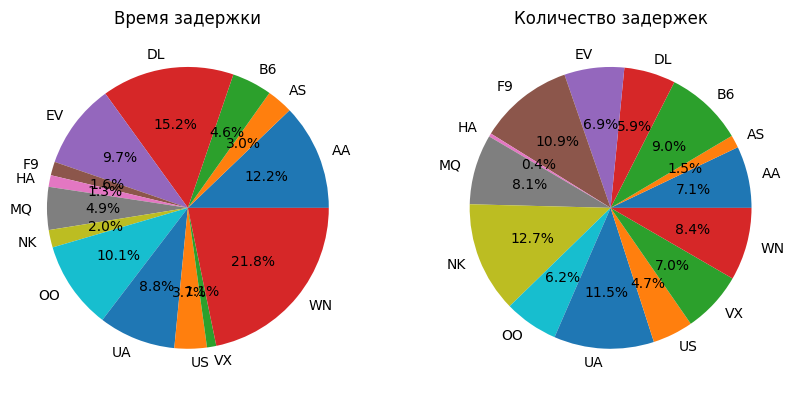

In [325]:
fig, axs = plt.subplots(1, 2, figsize = (10, 7))
airlines_data = df.groupby('AIRLINE')

mean_delay = airlines_data['DEPARTURE_DELAY'].mean()
amount_of_delay = airlines_data['DEPARTURE_DELAY'].count()

print("Corr = ", np.corrcoef(mean_delay/sum(mean_delay), amount_of_delay/sum(amount_of_delay))[0,1])

axs[0].pie(100 * amount_of_delay/sum(amount_of_delay), labels=amount_of_delay.index, autopct='%1.1f%%')
axs[1].pie(100 * mean_delay/sum(mean_delay), labels=mean_delay.index, autopct='%1.1f%%')
axs[0].set_title('Время задержки')
axs[1].set_title('Количество задержек')
plt.show()

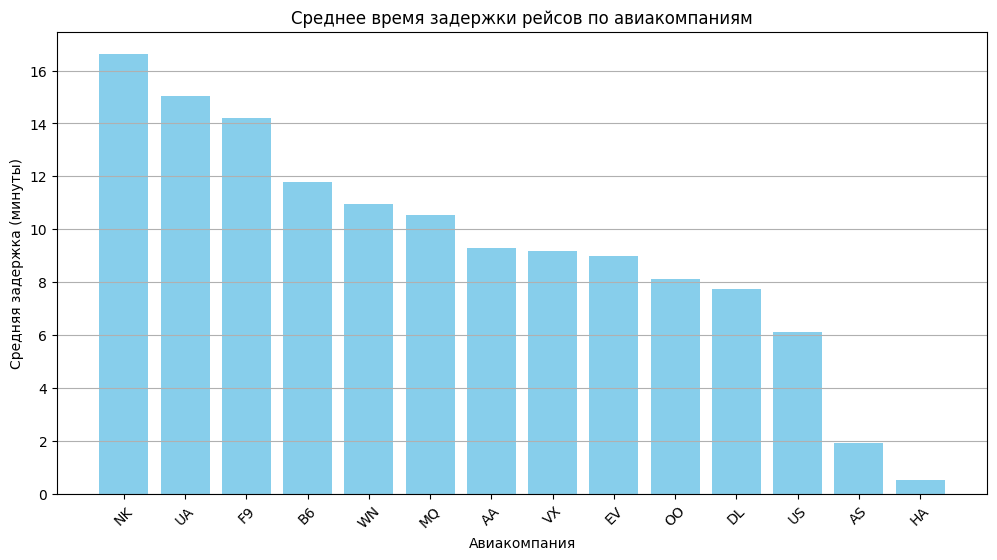

In [326]:
avg_delay_by_ariline = df.groupby('AIRLINE')['DEPARTURE_DELAY'].mean().reset_index().dropna().sort_values(by='DEPARTURE_DELAY', ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(avg_delay_by_ariline['AIRLINE'], avg_delay_by_ariline['DEPARTURE_DELAY'], color='skyblue')
plt.title('Среднее время задержки рейсов по авиакомпаниям')
plt.xlabel('Авиакомпания')
plt.ylabel('Средняя задержка (минуты)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


On the first plor we can see the "distribution" of the delays by the airlines: procentage of time delays and amount of delays, they are not correlated at all, so we can tell, that not the huge amount of delays give us the most problems, but some special cases. 

The second plot brings out the most problematic airlines, so we can tell, which airline we should give a warning next time. As we can see, for example, Spirit Air Lines (NK) delay about 17 min in mean, which is pretty huge, so maybe a smalltalk is needed here.

4. Weather delays

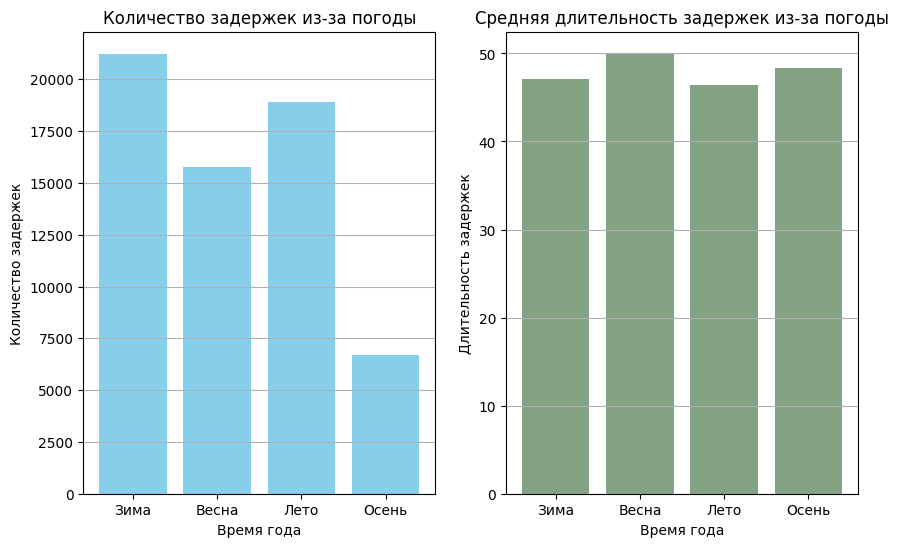

In [327]:
df['SEASON'] = df['DATE'].dt.month % 12 // 3 + 1

df['WEATHER_DELAY'] = pd.to_numeric(df['WEATHER_DELAY'], errors='coerce').fillna(0)
weather_delays = df[df['WEATHER_DELAY'].astype(int) > 0]

season_counts = weather_delays['SEASON'].value_counts().sort_index()
season_avg = weather_delays.groupby('SEASON')['WEATHER_DELAY'].mean()

fig, axs = plt.subplots(1, 2, figsize = (10, 6))

axs[0].bar(['Зима', 'Весна', 'Лето', 'Осень'], season_counts, color='skyblue')
axs[0].set_title('Количество задержек из-за погоды')
axs[0].set_xlabel('Время года')
axs[0].set_ylabel('Количество задержек')
axs[0].grid(axis='y')

color = (0.2, # redness
         0.4, # greenness
         0.2, # blueness
         0.6 # transparency
         ) #взял шаблончик из интернета

axs[1].bar(['Зима', 'Весна', 'Лето', 'Осень'], season_avg, color=color)
axs[1].set_title('Средняя длительность задержек из-за погоды')
axs[1].set_xlabel('Время года')
axs[1].set_ylabel('Длительность задержек')
axs[1].grid(axis='y')

plt.show()

As we can see, weather delays aren't so clear. The mean time of weather delays stays the same, not being affected by the season. But winter months hold the most amounts of delays, which is reasonable. For my own surprise the second season by the amount of weather delays is summer (was hoping for autumn at least), maybe it's because of the heat waves that occur during summer, because the stats take place in the US. 

This actually tells us a lot, because it shows that the weather is a major factor in long flight delays (more than 40 min in mean!), and that the safest season to fly is surprisingly autumn.

Can't actually do much about weather by ourselfs, but we can be prepared for it. If you're planning a trip, check the weather forecast before you get tickets.

5. Does distance affect the delay?

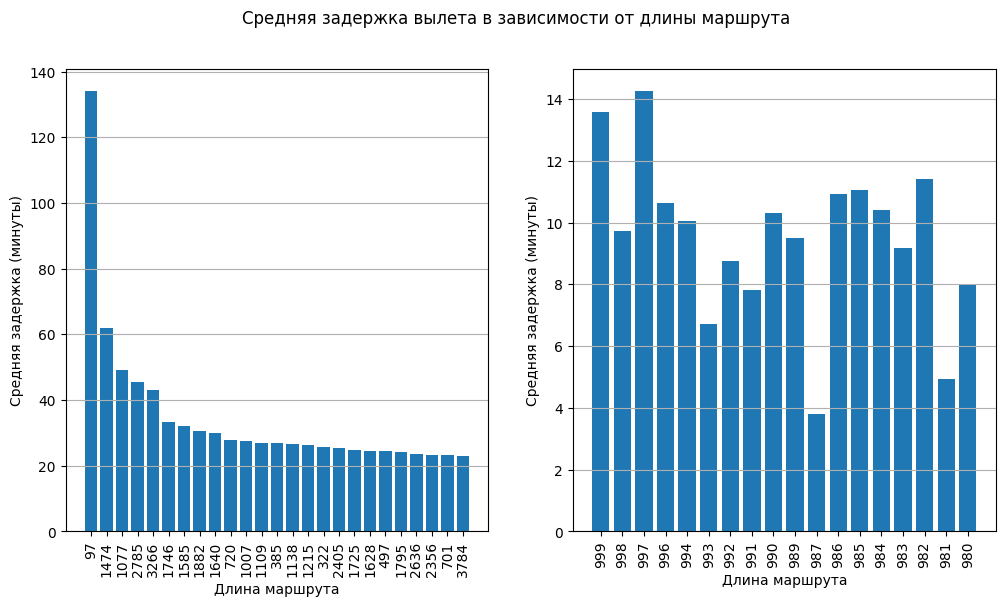

Corr =  -0.02843131381325722


In [335]:
avg_dist_delay = df.groupby('DISTANCE')['DEPARTURE_DELAY'].mean().reset_index().dropna()
tmp = df.groupby('DISTANCE')['SEASON'].nunique().reset_index()
tmp = tmp.merge(avg_dist_delay, on = 'DISTANCE').sort_values(by = 'DEPARTURE_DELAY', ascending=False)

fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].bar(tmp['DISTANCE'][:25], tmp['DEPARTURE_DELAY'][:25])
axs[0].set_xlabel('Длина маршрута')
axs[0].set_ylabel('Средняя задержка (минуты)')
axs[0].grid(axis='y')
axs[0].set_xticks(range(25))
axs[0].set_xticklabels(tmp['DISTANCE'][:25], rotation=90)

tmp = tmp.sort_values(by = 'DISTANCE', ascending=False)

axs[1].bar(tmp['DISTANCE'][:18], tmp['DEPARTURE_DELAY'][:18])
axs[1].set_xlabel('Длина маршрута')
axs[1].set_ylabel('Средняя задержка (минуты)')
axs[1].grid(axis='y')
axs[1].set_xticks(range(18))
axs[1].set_xticklabels(tmp['DISTANCE'][:18], rotation=90)

fig.suptitle('Средняя задержка вылета в зависимости от длины маршрута')
plt.show()

print('Corr = ', np.corrcoef( df.groupby('DISTANCE')['DEPARTURE_DELAY'].mean().dropna(), df.groupby('DISTANCE').size() )[0,1] )

As we can see, the distance doesn't quite affect the delays of the flights. On the first plot we can see, that the most "delayed" flight is not so long, and in the first 25 we can see some of the shortest flights. This is because the delay is not directly related to the distance of the flight, even the correlation says so.

And on the second one, which came out not so informative, is aranged by the length of the flight, we can see, that with the drop of the length, the amount of delay doesn't quite drop. It just balances there. So to conclude we can say, that the length of the flight is not a good indicator of the delay. Even though we can see, that the flights with length of 97km are weirdly long delayed. Maybe do somethng about it.